# Changing the model

Reminder: we're performing this minimization:

$$\widehat{w} = \arg\min_{w}L(w)$$


**Takeaway:** more complex models → more difficult optimizaiton.

Below, let's look at the following:

* General functions (all loss/modles will be abstracted away).
* Changing models

## Functions

There are 3 classes of functions:

* "Strongly convex"
    * One global minimizer.
* "Convex"
    * Many global minimizers (i.e., flat areas are possible)
* "Non-convex" or "smooth"
    * Minimizers may be local.
    
Here's an illustration:

<AxesSubplot:title={'center':'Non-convex'}, xlabel='x'>

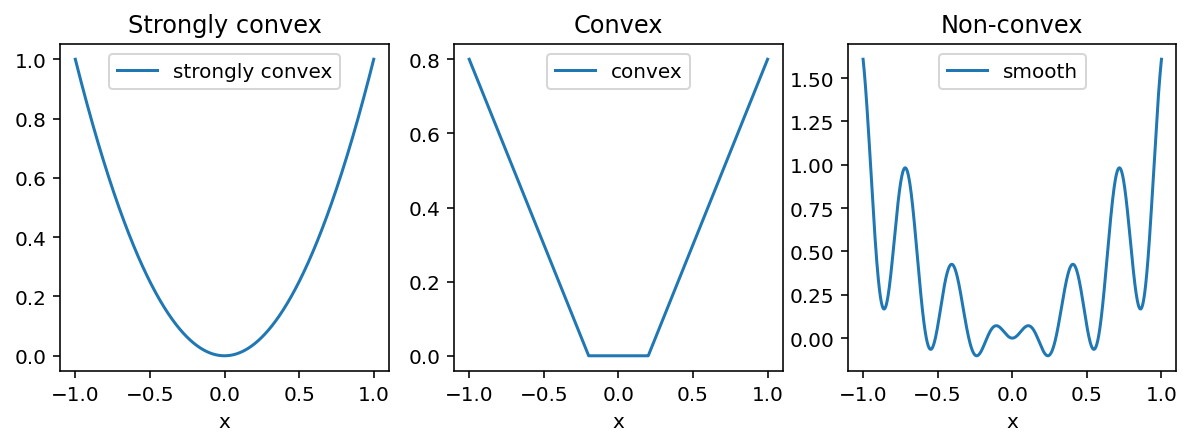

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-1, 1, num=1000)
df = pd.DataFrame({"x": x,
    "strongly convex": x**2,
    "convex": np.clip(np.abs(x) - 0.2, 0, 100),
    "smooth": (x/1.5) * np.sin(x*20) + 1*x**2,
})

fig, axs = plt.subplots(figsize=(10, 3), ncols=3)
df.plot(x="x", y="strongly convex", ax=axs[0], title="Strongly convex")
df.plot(x="x", y="convex", ax=axs[1], title="Convex")
df.plot(x="x", y="smooth", ax=axs[2], title="Non-convex")

Strongly convex and convex are the easiest: the negative gradient always points towards a global minimizer.

# Models

Model are the biggest difference between classes.

* **Neural network?** Non-convex.
* **Anything else?** Convex or non-convex

All "generalized linear models"—which are very general—are at least convex. The following are examples of "generalized linear models":

* All "generalized linear models":
    * ANOVA/ANCOVA
    * Logistic, linear and Poisson regression
    * Single layer neural networks
* Pearson correlation coefficient

More detail is at this blog post (https://lindeloev.github.io/tests-as-linear/) or this lecture from PSU Stat 504 lecture (https://online.stat.psu.edu/stat504/lesson/6/6.1).

Non-convexity is added by products between weights, complex non-linearities (non-monotonic, etc).



# How does optimization change depending on function class?

What does optimization do? It takes *steps* in the direction of the negative gradient:

$$w_{k+1} = w_k - \gamma g(w_k)$$

This says "go in the direction of steepest descent."

In [2]:
from IPython.display import Image
Image(url="https://erlendd.github.io/assets/images/optimization/gradient_descent_quartic.gif",
      width=600)

* Strongly convex: gradient descent is fine
* Non-convex: some changes are needed to get over that "bump."

A parameter called "momentum" allows going over bumps.

That's best illustrated with this example:

In [3]:
from IPython.display import Video
Video(data="./assets/grad_descent.mp4", embed=True, height=300)

The red dot has `momentum=0`. The green dot has `momentum=0.8`. For more detail, see https://stsievert.com/blog/2016/01/30/inverse-3/ (note: choose `momentum=0.9`; it's a standard for machine learning).

This same momentum parameter is found in [torch.optim.SGD][sgd].

It's another user-specified "hyperparameter."

[sgd]:https://pytorch.org/docs/stable/generated/torch.optim.SGD.html

* **Gradient descent hyperparameters:**
    * Learning rate $\gamma$
* **Gradient descent with momentum hyperparameters:**
    * Learning rate $\gamma$
    * Momentum ($=0.9$).

## Choosing hyperparameters

Luckily these methods to avoid this:

* Convex/strongly convex:
    * Most of Scikit-Learn's linear modles (e.g., [Ridge][1]) have this built in.
    * [torch.optim.LBFGS][L].
* Non-convex:
    * [torch.optim.Adadelta][1a]
    * [torch.optim.AdamW][2a]

[1a]:https://pytorch.org/docs/stable/generated/torch.optim.Adadelta.html
[2a]:https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html#torch.optim.AdamW

[1]:https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge
[ASGD]:https://pytorch.org/docs/stable/generated/torch.optim.ASGD.html#torch.optim.ASGD
[L]:https://pytorch.org/docs/stable/generated/torch.optim.LBFGS.html#torch.optim.LBFGS
[AdamW]:https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html#torch.optim.AdamW
[Adadelta]:https://pytorch.org/docs/stable/generated/torch.optim.Adadelta.html#torch.optim.Adadelta

### What are these methods doing?

Essentially doing a search to find a good step size.

In [4]:
from IPython.display import Image
Image(url="https://cdn-images-1.medium.com/max/1600/0*QwE8M4MupSdqA3M4.png",
      width=400
     )

# Conclusion

* Simple models → simple optimization.
* Basics of what optimization algorithms perform.

# Examples

These examples use my favorite deep learning software:

* [PyTorch], developed by Facebook.
* [Skorch], a (thin) declartive wrapper that abstracts details away (and provides a Scikit-learn API to PyTorch.

[PyTorch]:https://pytorch.org/
[Skorch]:https://skorch.readthedocs.io/en/stable/

How do you change the optimizer?

In [5]:
import torch
import torch.nn as nn
import numpy as np
from utils import Optimizer

In [6]:
class SingleLayerNN(nn.Module):

    def __init__(self, features=20):
        super().__init__()
        self.layer = nn.Linear(features, 1)
        
    def forward(self, x):
        combo = self.layer(x)
        return torch.sigmoid(combo)

**This model is linear.** Yes, a non-linear sigmoid function is used but it still fits in the generalized linear model framework.

**Simple model → convex.** Generalized linear models are at least convex.


In [7]:
import torch.optim as optim

est = Optimizer(
    module=SingleLayerNN,
    optimizer=optim.LBFGS,
).initialize()

x = np.random.uniform(size=20).astype("float32")
est.predict(x)

array([0.626981], dtype=float32)

### Using Python in your model is okay

In [8]:
class SingleLayerNN2(nn.Module):

    def __init__(self, features=20, function="sigmoid"):
        super().__init__()
        self.layer = nn.Linear(features, 1)
        self.function = function
        
    def forward(self, x):
        combo = self.layer(x)
        if self.function == "sigmoid":
            return torch.sigmoid(combo)
        elif self.function == "tanh":
            return torch.tanh(combo)

In [9]:
est = Optimizer(module=SingleLayerNN2, module__function="tanh").initialize()

x = np.random.uniform(size=20).astype("float32")
est.predict(x)

array([-0.28570813], dtype=float32)